In [105]:
nfcore_results = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/barplot/"

In [106]:
metadata_original = "./tables/original"

In [ ]:
# merge metadata sampleinfo and clincial metadata

In [ ]:
## leer nfcore results

In [ ]:
#mergear results nfcore with metadata clinical

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load the dataset
file_path = "./tables/level-6_old.csv"
df = pd.read_csv(file_path)
#df["condition"].replace("Diabetes mellitus Typ1", "Diabetes mellitus Type1",inplace=True)
#df["condition"].replace("pankreopriver Diabetes", "Pankreopriver Diabetes",inplace=True)
## Extract metadata and microbial abundance data
#metadata_cols = ["index", 'sample_information', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
#       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
#       'BMI1', 'BMI2', 'Pankreatektomie', 'HbA1C_diff', 'Glukose_diff',
#       'BMI_diff', 'KHK_diff', 'CA_diff', 'condition', 'sex', 'nikotin']
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Normalize microbial abundances (convert to relative abundance)
#microbial_data = microbial_data.div(microbial_data.sum(axis=1), axis=0)

# Add condition column back for grouping
microbial_data["condition"] = df["condition"]


# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(microbial_data.drop(columns=["condition"], errors='ignore'))

# Create PCA DataFrame for visualization
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["condition"] = df["condition"]


# Define custom color palette
custom_pclette = {
    "Kontrolle": "#1f77b4",               # blue
    "Diabetes mellitus Type1": "#ff7f0e", # orange
    "Pankreopriver Diabetes": "#2ca02c"   # green
}

# Plot PCA results with custom colors
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="condition",
    palette=custom_palette,
    alpha=0.7,
    s=100
)

plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.title("PCA of Microbial Composition")
plt.legend(title="", fontsize=12)
plt.tight_layout()
plt.savefig("pca.svg")
plt.show()



In [9]:
import pandas as pd

# Load the dataset
file_path = "./tables/level-7.csv"
df = pd.read_csv(file_path)

# Define metadata columns
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]

# Function to extract and clean microbial data by condition
def extract_microbial_data(df, condition_label):
    subset = df[df["sample_information"].str.startswith(condition_label)]
    microbial_data = subset.drop(columns=metadata_cols, errors='ignore')
    microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]
    microbial_data = microbial_data.loc[:, ~microbial_data.columns.str.startswith("Archaea;")]
    return microbial_data

# Create three microbial datasets
microbial_data_PDM = extract_microbial_data(df, "PDM")
microbial_data_DM = extract_microbial_data(df, "DM")
microbial_data_Kontrolle = extract_microbial_data(df, "K")


In [10]:
# Extract microbial abundance data (exclude metadata)
list_PDM = set(microbial_data_PDM.columns)
list_DM = set(microbial_data_DM.columns)
list_Kontrolle = set(microbial_data_Kontrolle.columns)

In [11]:
common_PDM_DM = list_PDM &  list_DM

In [12]:
notcommon_PDM_DM = list_PDM ^  list_DM

# Unique to PDM
unique_PDM = list_PDM - list_DM - list_Kontrolle

# Unique to DM
unique_DM = list_DM - list_PDM - list_Kontrolle

# If you want to convert them to sorted lists for display or export:
common_PDM_DM = sorted(list(common_PDM_DM))
unique_PDM = sorted(list(unique_PDM))
unique_DM = sorted(list(unique_DM))

In [13]:
import pandas as pd

# Load the dataset
file_path = "./tables/level-7.csv"
df = pd.read_csv(file_path)
# Define metadata columns
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]

microbial_data = df.drop(columns=metadata_cols, errors='ignore')
microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]


def extract_microbial_data(df, condition_label):
    subset = df[df["sample_information"].str.startswith(condition_label)]
    microbial_data = subset.drop(columns=metadata_cols, errors='ignore')
    microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]
    return microbial_data

# Create three microbial datasets
microbial_data_PDM = extract_microbial_data(df, "PDM")
microbial_data_DM = extract_microbial_data(df, "DM")

list_PDM = set(microbial_data_PDM.columns)
list_DM = set(microbial_data_DM.columns)

common_PDM_DM = list_PDM - list_DM
# If you want to convert them to sorted lists for display or export:
common_PDM_DM = sorted(list(common_PDM_DM))



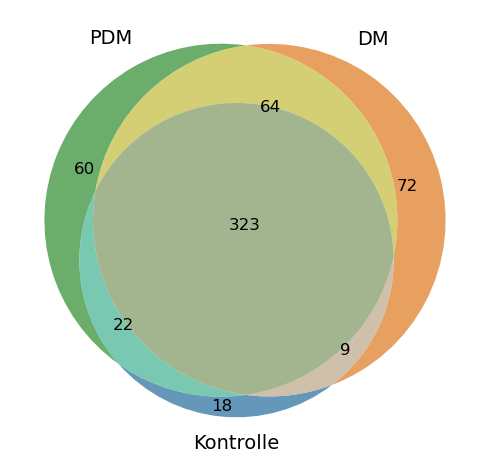

In [14]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Sample sets (replace with yours)
# list_PDM, list_DM, list_Kontrolle

plt.figure(figsize=(5, 5))

venn = venn3(
    subsets=[set(list_PDM), set(list_DM), set(list_Kontrolle)],
    set_labels=("PDM", "DM", "Kontrolle"),
    set_colors=("#3A923A", "#E1812C", "#3274A1"),  # green, blue, orange
    alpha=0.75  # Full opacity for bold look
)

# Make labels bold and slightly bigger
for text in venn.set_labels:
    if text:  # sometimes one may be None
        text.set_fontsize(14)


for text in venn.subset_labels:
    if text:
        text.set_fontsize(12)


# Optional: Adjust title and remove excess whitespace

plt.tight_layout()
plt.savefig("venn.svg")
plt.show()


/tmp/ipykernel_2537045/204407449.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

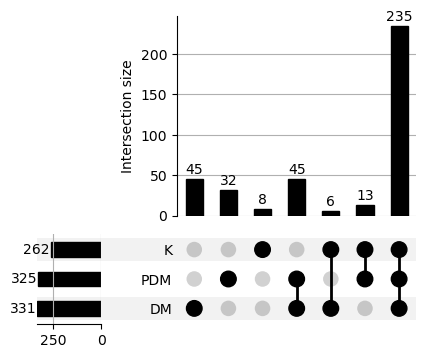

In [102]:
import pandas as pd
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt


# Assume you already have these:
# microbial_data_PDM, microbial_data_DM, microbial_data_Healthy

# Get sets of taxa present in each group
taxa_PDM = set(microbial_data_PDM.columns)
taxa_DM = set(microbial_data_DM.columns)
taxa_K = set(microbial_data_Kontrolle.columns)


# Create a list of presence/absence combinations
taxa_all = taxa_PDM | taxa_DM  | taxa_K

memberships = []
for taxon in taxa_all:
    presence = []
    if taxon in taxa_PDM:
        presence.append("PDM")
    if taxon in taxa_DM:
        presence.append("DM")
    if taxon in taxa_K:
        presence.append("K")
  
    memberships.append(presence)c

# Convert to format UpSet needs
data = from_memberships(memberships)

# Plot UpSet
plt.figure(figsize=(10, 6))
UpSet(data, subset_size='count', show_counts=True).plot()
plt.title("")
plt.tight_layout()
plt.savefig("upsetplot.svg")
plt.show()


# Unique to PDM
shared_PDM_DM_only = (taxa_PDM & taxa_DM) - taxa_K

# Unique to DM
unique_PDM = taxa_PDM - taxa_DM - taxa_K

# Unique to DM
unique_DM = taxa_DM - taxa_PDM - taxa_K

# Unique to DM
unique_K = taxa_K - taxa_DM - taxa_PDM 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Define the file path
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/barplot/level-4.csv"

# Load the CSV file
df = pd.read_csv(file_path)

# Extract microbial abundance data (exclude metadata)
metadata_cols = ["index", "sample_information", "condition", "nikotin", "sex", "age_group", "AH"]
microbial_data = df.drop(columns=metadata_cols, errors='ignore')

# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()

microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

# Remove empty column names ("")
microbial_data = microbial_data.loc[:, microbial_data.columns != ""]

# Add condition column back
microbial_data["condition"] = df["condition"]

# Filter for only "pankreopriver Diabetes" and "Kontrolle"
df_filtered = microbial_data[microbial_data["condition"].isin(["pankreopriver Diabetes", "Diabetes mellitus Typ1"])].copy()

# Convert condition to binary (1 = PDM, 0 = Kontrolle)
df_filtered["condition"] = df_filtered["condition"].map({"pankreopriver Diabetes": 1, "Diabetes mellitus Typ1": 0})

# Prepare results storage
results = []

# Perform differential abundance analysis (negative binomial regression like DESeq2)
for taxon in df_filtered.columns[:-1]:  # Exclude 'condition' column
    # Ensure values are numeric
    df_filtered[taxon] = pd.to_numeric(df_filtered[taxon], errors='coerce')

    # Fit a Negative Binomial Model
    try:
        model = smf.glm(f"{taxon} ~ condition", data=df_filtered, family=sm.families.NegativeBinomial()).fit()
        log_fold_change = model.params["condition"]
        p_value = model.pvalues["condition"]
        results.append((taxon, log_fold_change, p_value))
    except:
        continue  # Skip taxa where model fitting fails

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Taxon", "Log2 Fold Change", "p-value"])

# Adjust p-values using Benjamini-Hochberg (FDR correction)
results_df["Adjusted p-value"] = multipletests(results_df["p-value"], method="fdr_bh")[1]

# Create a Volcano Plot to visualize differential abundance results

# Define significance threshold
significance_threshold = 0.05

# Create a new column for significance labeling
results_df["Significance"] = results_df["Adjusted p-value"] < significance_threshold

# Create Volcano Plot
plt.figure(figsize=(5,10))
sns.scatterplot(
    x=results_df["Log2 Fold Change"],
    y=-np.log10(results_df["Adjusted p-value"]),
    hue=results_df["Significance"],
    palette={True: "red", False: "gray"},
    edgecolor="black",
    alpha=0.7
)

# Add labels for significant points
for i, row in results_df.iterrows():
    if row["Significance"]:
        plt.text(row["Log2 Fold Change"], -np.log10(row["Adjusted p-value"]), row["Taxon"], fontsize=15, ha='right')


logfoldchange_threshold= 1
# Labels and title
plt.axhline(-np.log10(significance_threshold), linestyle="--", color="blue", linewidth=1)  # Threshold line
plt.axvline(x=-logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC negative threshold
plt.axvline(x=logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC positive threshold
plt.xlabel("Log2FC",fontsize=15, )
plt.ylabel("-log10(p.ajust)",fontsize=15, )
plt.title("PDM vs. DM")
plt.legend(title="FDR < 0.05", loc="upper right")
plt.xlim(-25, 25)
#plt.savefig("volcano_pdm_dn.svg")
# Show plot
plt.show()


In [ ]:
metadata_alpha = pd.read_csv("metadata.tsv", sep  ="\t")

In [128]:
metadata_alpha["Condition"].replace("Diabetes mellitus Typ1", "DM",inplace=True)
metadata_alpha["Condition"].replace("pankreopriver Diabetes", "PDM",inplace=True)

/tmp/ipykernel_3448027/75077750.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x="Condition", y="shannon_entropy", palette=custom_palette,  order=order)


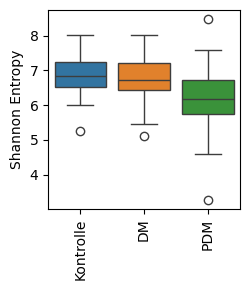

In [148]:
# Remove non-numeric values and convert the column to float
df_clean = metadata_alpha[pd.to_numeric(metadata_alpha["shannon_entropy"], errors="coerce").notnull()].copy()
df_clean["shannon_entropy"] = df_clean["shannon_entropy"].astype(float)
order = ["Kontrolle", "DM", "PDM"]
custom_palette = {
    "Kontrolle": "#1f77b4",  # blue
    "DM": "#ff7f0e",  # orange
    "PDM": "#2ca02c",  # green
}

# Create the boxplot
plt.figure(figsize=(2.6,3))
sns.boxplot(data=df_clean, x="Condition", y="shannon_entropy", palette=custom_palette,  order=order)
plt.xticks(rotation=90)
#sns.stripplot(data=df_clean, x="Condition", y="shannon_entropy", color="black", alpha=0.5, jitter=True)

plt.title("")
plt.xlabel("", rotation=45)
plt.ylabel("Shannon Entropy")
plt.tight_layout()
plt.savefig("alpha_diversity.svg")
plt.show()


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Load your abundance table
df = pd.read_csv("./tables/level-6.csv")

In [2]:
df = df.set_index("index")


In [3]:
# Remove metadata and filter Archaea
metadata_cols = ['sample_information', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
       'BMI1', 'BMI2', 'Pankreatektomie', 'HbA1C_diff', 'Glukose_diff',
       'BMI_diff', 'KHK_diff', 'CA_diff', 'condition', 'sex', 'nikotin']

In [4]:
taxa_data = df.drop(columns=metadata_cols, errors='ignore')
taxa_data = taxa_data.loc[:, ~taxa_data.columns.str.startswith("Archaea;")]
taxa_data.columns = [col.split(";")[-1] for col in taxa_data.columns]  # Last taxonomy level

In [5]:

# Normalize (relative abundance per sample)
taxa_data = taxa_data.div(taxa_data.sum(axis=1), axis=0)

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("./tables/level-6.csv")


# Fix condition names
df["condition"] = df["condition"].replace({
    "Diabetes mellitus Typ1": "DM",
    "pankreopriver Diabetes": "PDM",
    "Kontrolle": "K"
})

# Metadata to use as annotation
metadata_cols = ['sample_information', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
       'BMI1', 'BMI2', 'Pankreatektomie', 'HbA1C_diff', 'Glukose_diff',
       'BMI_diff', 'KHK_diff', 'CA_diff', 'condition', 'sex', 'nikotin']

metadata = df[metadata_cols].set_index("sample_information")

# Prepare microbial abundance matrix

microbial_data = df.drop(columns=["index", "condition", "nikotin", "sex", "age_group", "AH"], errors='ignore')

microbial_data.set_index(df["sample_information"], inplace=True)
microbial_data = microbial_data.loc[:, ~microbial_data.columns.str.startswith("Archaea;")]

In [34]:
metadata["Pankreatektomie"] = metadata["Pankreatektomie"].replace({
    'nein': 'no',
    'Teilresektion rechts': "Partial resection right",
    'Teilresektion links': "Partial resection left",
    'Resektion': "Resection"
})


In [35]:
metadata["nikotin"] = metadata["nikotin"].replace({
    'nein': 'no',
    'ja': "yes",
})


In [36]:
microbial_data = microbial_data[shared_PDM_DM_only]

In [37]:
microbial_data.columns = [col.split(";")[-1] for col in microbial_data.columns]

In [38]:
# Remove zero-only taxa
microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]

In [39]:
# Remove non-numeric columns just in case
microbial_data = microbial_data.select_dtypes(include=["number"])

In [40]:
nonzero_rows = microbial_data.sum(axis=1) != 0
microbial_data = microbial_data[nonzero_rows]
microbial_data = microbial_data.div(microbial_data.sum(axis=1), axis=0)

In [41]:
# Align metadata
metadata = metadata.loc[microbial_data.index]

# Define row color annotations (samples)
row_colors = pd.DataFrame({
  
    "BMI_diff": metadata["BMI_diff"].map({
         "increase": "#d7191c", 
        "decrease": "#2b83ba"
    }),
    "Glukose_diff": metadata["Glukose_diff"].map({
        "increase": "#d7191c", 
        "decrease": "#2b83ba"
    }),  "HbA1C_diff": metadata["HbA1C_diff"].map({
            "increase": "#d7191c", 
        "decrease": "#2b83ba"
    }),
    "KHK_diff": metadata["KHK_diff"].map({
        "onset": "#a6cee3", 
        "absent": "#b2df8a", 
        "persistent": "#1f78b4", 
        "resolved": "#33a02c"
    }),
  
    "CA_diff": metadata["CA_diff"].map({
        "onset": "#a6cee3", 
        "absent": "#b2df8a", 
        "persistent": "#1f78b4"
    }),
    "nikotin": metadata["nikotin"].map({
        "yes": "#f1a340", 
        "no": "#998ec3"
    }),  "Pankreatektomie": metadata["Pankreatektomie"].map({
        "no": "#998ec3", 
        'Partial resection right': "#a6d96a",
        'Partial resection left':"#1a9641",
        "Resection": "#fdae61"
    }),
    # Optional: you had this commented out
    # "condition": metadata["condition"].map({
    #     "PDM": "#2ca02c", 
    #     "DM": "#ff7f0e", 
    #     "K": "#1f77b4"
    # }),
    "sex": metadata["sex"].map({
        "male": "#8da0cb", 
        "female": "#fc8d62"
    })
}, index=metadata.index)

microbial_data = microbial_data.loc[:, microbial_data.columns != ""]

In [42]:
def sort_key(index):
    if str(index).startswith("K"):
        return (0, index)
    elif str(index).startswith("DM"):
        return (1, index)
    elif str(index).startswith("PDM"):
        return (2, index)
    else:
        return (3, index)  # In case there are other types

microbial_data = microbial_data.loc[sorted(microbial_data.index, key=sort_key)]

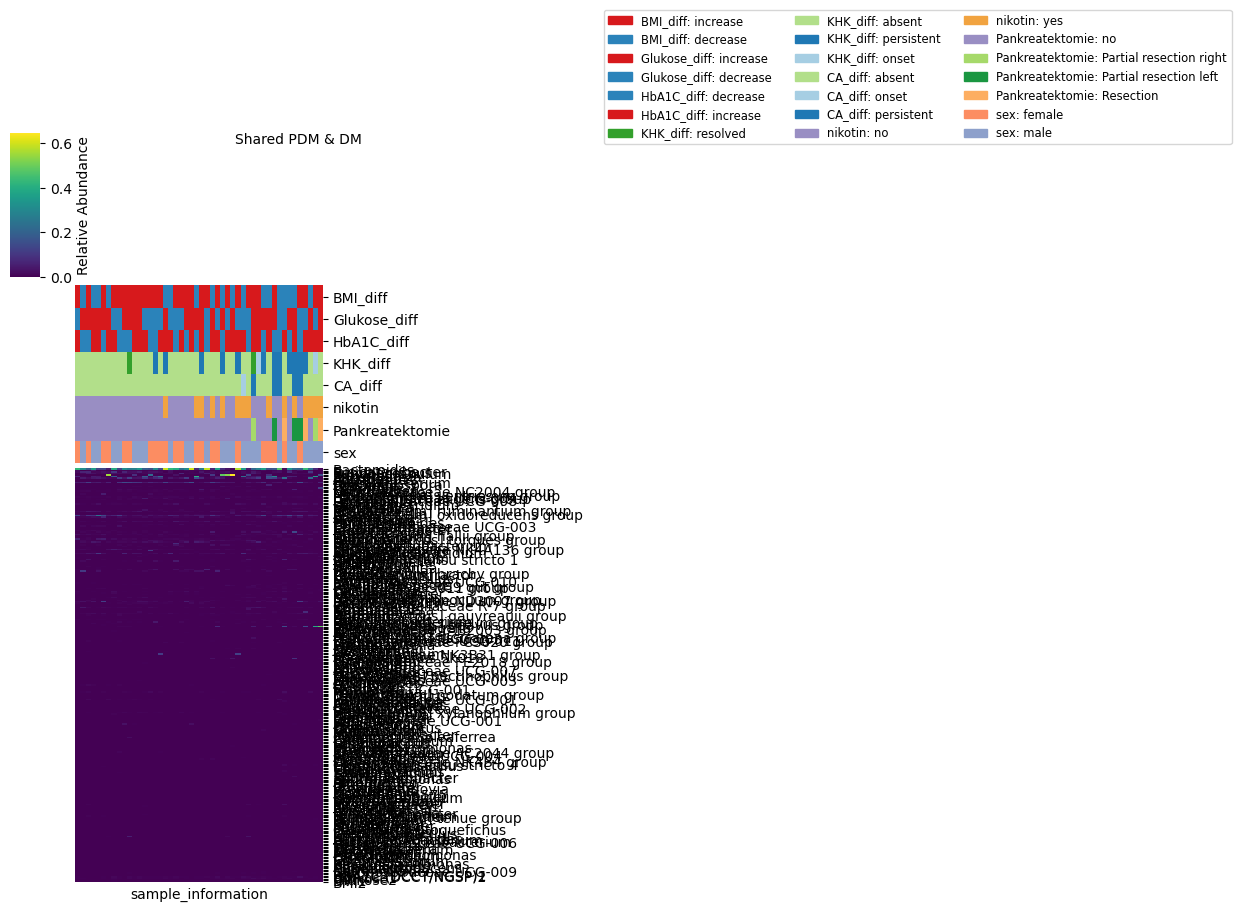

In [43]:
import matplotlib.patches as mpatches
# Clustered heatmap
g = sns.clustermap(
    microbial_data.T,  # taxa on rows, samples on columns
    row_cluster=False,
    col_cluster=False,
    col_colors=row_colors,
    cmap="viridis",
    figsize=(6, 8),
    xticklabels=False,
    yticklabels=True,
    cbar_kws={'label': 'Relative Abundance'}
)
legend_labels = {}
for col in row_colors.columns:
    for val in metadata[col].unique():
        color = row_colors.loc[metadata[col] == val, col].iloc[0]
        label = f"{col}: {val}"
        legend_labels[label] = color

# Create handles for legend
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]

# Place legend
g.ax_col_dendrogram.legend(
    handles=handles,
    loc='center left',
    bbox_to_anchor=(1, 1.05),
    bbox_transform=plt.gcf().transFigure,
    ncol=3,  # Adjust based on space
    fontsize='small'
)

plt.suptitle("Shared PDM & DM", fontsize=10)
plt.xlabel("", rotation=45)
plt.savefig("clustermap_taxa_vs_samples_shared_PDM_DM_only.svg")
plt.show()
